<a href="https://colab.research.google.com/github/human-ai2025/Elo-Merchant-Recommendation/blob/master/Models/ModelExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [11]:
#--------------- DATA HANDLING AND MANIPULATION LIBRARIES ---------------#
import random 
import pandas as pd
import numpy as np
import os
import gc
import pickle
from scipy.stats import uniform, truncnorm, randint
from scipy.stats import randint as sp_randint
import datetime
#---------------                 Warning                  ---------------#
import warnings 
warnings.filterwarnings('ignore')

#---------------        Visualization Libraries           ---------------#
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

#---------------        Machine Learning  Libraries       ---------------#
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, KFold
from sklearn.model_selection import train_test_split


## Memory Reduction Script

In [2]:

#https://www.kaggle.com/fabiendaniel/elo-world
#Function to load data into pandas and reduce memory usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Mounting the drive

In [3]:
#Mounting drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set Path

In [4]:
%cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


## Load Train and Test

In [5]:
#load train
train = reduce_mem_usage(pd.read_csv('FINAL_TRAIN_M.csv'))
test = reduce_mem_usage(pd.read_csv('FINAL_TEST_M.csv'))

Mem. usage decreased to 99.56 Mb (71.3% reduction)
Mem. usage decreased to 62.01 Mb (70.6% reduction)


## Load the columns to take

In [6]:
columnsToTake = pickle.load(open("columnsToTake.pkl", 'rb')) 

## Model Exploration 

In [8]:
train

,Unnamed: 0,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,quarter,elapsed_time,feature_sum,feature_mean,feature_max,feature_min,feature_std,purchase_Year_mode,purchase_Week_sum,purchase_Week_mean,purchase_Week_std,purchase_Day_sum,purchase_Day_mean,purchase_Day_std,purchase_Dayofyear_sum,purchase_Dayofyear_mean,purchase_Dayofyear_std,purchase_Is_month_end_sum,purchase_Is_month_end_mean,purchase_Is_month_end_std,purchase_Is_month_start_sum,purchase_Is_month_start_mean,purchase_Is_month_start_std,purchase_Is_quarter_end_sum,purchase_Is_quarter_end_mean,purchase_Is_quarter_end_std,purchase_Is_quarter_start_sum,purchase_Is_quarter_start_mean,purchase_Is_quarter_start_std,purchase_Is_year_end_sum,purchase_Is_year_end_mean,purchase_Is_year_end_std,...,mer_avg_purchases_lag6_sum,mer_avg_purchases_lag6_mean,mer_avg_purchases_lag6_min,mer_avg_purchases_lag6_max,mer_avg_purchases_lag6_std,mer_avg_purchases_lag12_sum,mer_avg_purchases_lag12_mean,mer_avg_purchases_lag12_min,mer_avg_purchases_lag12_max,mer_avg_purchases_lag12_std,mer_active_months_lag3_sum,mer_active_months_lag3_mean,mer_active_months_lag3_min,mer_active_months_lag3_max,mer_active_months_lag3_std,mer_active_months_lag6_sum,mer_active_months_lag6_mean,mer_active_months_lag6_min,mer_active_months_lag6_max,mer_active_months_lag6_std,mer_active_months_lag12_sum,mer_active_months_lag12_mean,mer_active_months_lag12_min,mer_active_months_lag12_max,mer_active_months_lag12_std,mer_category_1_sum,mer_category_1_mean,mer_category_1_std,mer_most_recent_sales_range_sum,mer_most_recent_sales_range_mean,mer_most_recent_sales_range_std,mer_most_recent_purchases_range_sum,mer_most_recent_purchases_range_mean,mer_most_recent_purchases_range_std,mer_category_4_sum,mer_category_4_mean,mer_category_4_std,mer_category_2_sum,mer_category_2_mean,mer_category_2_std
0,0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,2017,2,1357,8,2.666016,5,1,2.082031,2017,8905,31.468750,15.554688,4411,15.585938,8.804688,61760,218.250,109.1875,9,0.031799,0.175781,7,0.024734,0.155640,5,0.017670,0.131958,3,0.010597,0.102600,1,0.003534,0.059448,...,5484.00,19.437500,0.321045,504.250000,93.312500,6044.00,21.437500,0.252930,554.500000,102.812500,846.0,3.000000,3.0,3.0,0.000000,1691.0,5.996094,5.0,6.0,0.059540,3348.0,11.875000,5.0,12.0,0.794434,258.0,0.915039,0.279541,469.0,1.663086,1.278320,410.0,1.454102,1.288086,16.0,0.056732,0.231812,294.0,1.042969,0.411133
1,1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392822,2017,1,1508,5,1.666992,4,0,2.082031,2017,8881,24.953125,16.703125,5914,16.609375,8.835938,61516,172.750,117.1875,12,0.033722,0.180786,15,0.042145,0.201172,6,0.016861,0.128906,6,0.016861,0.128906,3,0.008430,0.091553,...,1546.00,4.167969,0.307861,504.250000,36.937500,1679.00,4.527344,0.208984,554.500000,40.625000,1113.0,3.000000,3.0,3.0,0.000000,2226.0,6.000000,6.0,6.0,0.000000,4400.0,11.859375,7.0,12.0,0.788574,309.0,0.833008,0.373535,403.0,1.085938,1.363281,397.0,1.070312,1.364258,29.0,0.078186,0.268799,371.0,1.000000,0.000000
2,2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.687988,2016,3,1661,4,1.333008,2,0,1.154297,2017,807,18.343750,13.726562,859,19.515625,7.910156,5572,126.625,96.5000,1,0.022720,0.150757,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,...,61.97,1.376953,0.871094,15.859375,2.208984,62.84,1.396484,0.752441,16.218750,2.261719,135.0,3.000000,3.0,3.0,0.000000,270.0,6.000000,6.0,6.0,0.000000,533.0,11.843750,7.0,12.0,0.796387,43.0,0.955566,0.208374,18.0,0.399902,0.962891,18.0,0.399902,1.008789,3.0,0.066650,0.252197,205.0,4.554688,1.271484
3,3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142456,2017,3,1265,7,2.333984,4,0,2.082031,2017,2562,30.500000,17.140625,1391,16.562500,8.906250,17723,211.000,120.3750,3,0.035706,0.186646,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,...,230.90,2.404297,0.426270,15.859375,4.355469,234.10,2.437500,0.436035,16.218750,4.460938,288.0,3.000000,3.0,3.0,0.000000,576.0,6.000000,6.0,6.0,0.000000,1094.0,11.398438,7.

In [14]:
train['outliners'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1

In [16]:
train['outliners'].values

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
outliers = train['outliers']

In [20]:
target = train['target']

In [25]:
train = train[columnsToTake]

In [27]:
test = test[columnsToTake]

In [28]:
xgb_params = {'eta': 0.001, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True}


FOLDs = KFold(n_splits=5, shuffle=True, random_state=1989)

oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))


for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(train)):
    trn_data = xgb.DMatrix(data=train.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train.iloc[val_idx], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 2000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=100, verbose_eval=200)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb += xgb_model.predict(xgb.DMatrix(test), ntree_limit=xgb_model.best_ntree_limit+50) / FOLDs.n_splits

np.sqrt(mean_squared_error(oof_xgb, target))

xgb 0--------------------------------------------------
[0]	train-rmse:3.93274	valid-rmse:4.02925
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[200]	train-rmse:3.84476	valid-rmse:3.9588
[400]	train-rmse:3.77765	valid-rmse:3.90856
[600]	train-rmse:3.7252	valid-rmse:3.87277
[800]	train-rmse:3.68302	valid-rmse:3.84659
[1000]	train-rmse:3.64816	valid-rmse:3.82799
[1200]	train-rmse:3.61886	valid-rmse:3.8144
[1400]	train-rmse:3.59402	valid-rmse:3.80479
[1600]	train-rmse:3.57192	valid-rmse:3.79763
[1800]	train-rmse:3.55226	valid-rmse:3.7922
[1999]	train-rmse:3.53492	valid-rmse:3.78828
xgb 1--------------------------------------------------
[0]	train-rmse:3.96745	valid-rmse:3.89053
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[200]	train-rmse:3.87633	valid-rmse:3.82385
[400]	train-rmse:3.8067	va

3.7205543782022032

In [32]:
del trn_data
del val_data
del watchlist

In [31]:
len(predictions_xgb)

123623

In [33]:
lgb_params = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

FOLDs = KFold(n_splits=5, shuffle=True, random_state=1989)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

features_lgb = list(train.columns)
feature_importance_df_lgb = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(train)):
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx])

    print("LGB " + str(fold_) + "-" * 50)
    num_round = 2000
    clf = lgb.train(lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 2000)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df_lgb = pd.DataFrame()
    fold_importance_df_lgb["feature"] = features_lgb
    fold_importance_df_lgb["importance"] = clf.feature_importance()
    fold_importance_df_lgb["fold"] = fold_ + 1
    feature_importance_df_lgb = pd.concat([feature_importance_df_lgb, fold_importance_df_lgb], axis=0)
    predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / FOLDs.n_splits
    

del fold_importance_df_lgb
del trn_data
del val_data

print(np.sqrt(mean_squared_error(oof_lgb, target)))


LGB 0--------------------------------------------------
Training until validation scores don't improve for 2000 rounds.
[200]	training's rmse: 3.63797	valid_1's rmse: 3.81358
[400]	training's rmse: 3.54126	valid_1's rmse: 3.79052
[600]	training's rmse: 3.4739	valid_1's rmse: 3.78268
[800]	training's rmse: 3.42472	valid_1's rmse: 3.77889
[1000]	training's rmse: 3.38535	valid_1's rmse: 3.77697
[1200]	training's rmse: 3.35004	valid_1's rmse: 3.77561
[1400]	training's rmse: 3.31816	valid_1's rmse: 3.7751


Exception ignored in: <bound method Booster.__del__ of <xgboost.core.Booster object at 0x7f507115e160>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'
Exception ignored in: <bound method Booster.__del__ of <xgboost.core.Booster object at 0x7f5071084940>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


[1600]	training's rmse: 3.28895	valid_1's rmse: 3.77424
[1800]	training's rmse: 3.26219	valid_1's rmse: 3.77418
[2000]	training's rmse: 3.23562	valid_1's rmse: 3.77396
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 3.23562	valid_1's rmse: 3.77396
LGB 1--------------------------------------------------
Training until validation scores don't improve for 2000 rounds.
[200]	training's rmse: 3.66492	valid_1's rmse: 3.69768
[400]	training's rmse: 3.56634	valid_1's rmse: 3.68132
[600]	training's rmse: 3.4969	valid_1's rmse: 3.67693
[800]	training's rmse: 3.44515	valid_1's rmse: 3.67419
[1000]	training's rmse: 3.40467	valid_1's rmse: 3.67275
[1200]	training's rmse: 3.36971	valid_1's rmse: 3.67154
[1400]	training's rmse: 3.33803	valid_1's rmse: 3.67071
[1600]	training's rmse: 3.30813	valid_1's rmse: 3.67037
[1800]	training's rmse: 3.27978	valid_1's rmse: 3.66995
[2000]	training's rmse: 3.25305	valid_1's rmse: 3.67048
Did not meet early stopping. Best iteration is:
[2000

In [35]:
print("-----------------\nScores on train\n-----------------")
print('lgb:', np.sqrt(mean_squared_error(oof_lgb, target)))
print('xgb:', np.sqrt(mean_squared_error(oof_xgb, target)))

total_sum = 0.5*oof_lgb + 0.5*oof_xgb

print("CV score: {:<8.5f}".format(mean_squared_error(total_sum, target)**0.5))

-----------------
Scores on train
-----------------
lgb: 3.706500221034686
xgb: 3.7205543782022032
CV score: 3.70873 


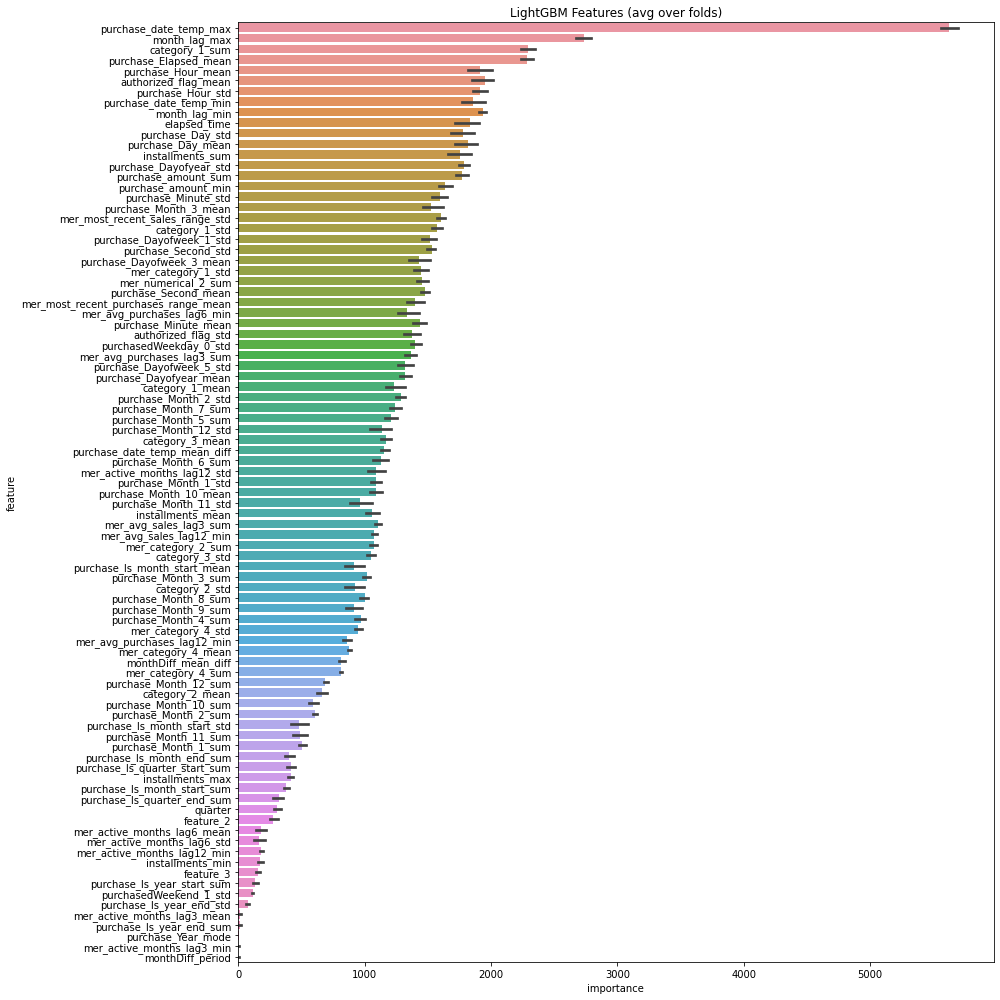

In [36]:
cols = (feature_importance_df_lgb[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df_lgb.loc[feature_importance_df_lgb.feature.isin(cols)]

plt.figure(figsize=(14,14))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')
del feature_importance_df_lgb

In [38]:
test = reduce_mem_usage(pd.read_csv('FINAL_TEST_M.csv'))
test['card_id']

Mem. usage decreased to 62.01 Mb (70.6% reduction)


0         C_ID_0ab67a22ab
1         C_ID_130fd0cbdd
2         C_ID_b709037bc5
3         C_ID_d27d835a9f
4         C_ID_2b5e3df5c2
               ...       
123618    C_ID_7a239d2eda
123619    C_ID_75ace375ae
123620    C_ID_21d56d950c
123621    C_ID_6c46fc5a9d
123622    C_ID_87e7979a5f
Name: card_id, Length: 123623, dtype: object

In [37]:
submission = pd.read_csv('sample_submission.csv')
submission 

,card_id,target
0,C_ID_0ab67a22ab,0
1,C_ID_130fd0cbdd,0
2,C_ID_b709037bc5,0
3,C_ID_d27d835a9f,0
4,C_ID_2b5e3df5c2,0
...,...,...
123618,C_ID_7a239d2eda,0
123619,C_ID_75ace375ae,0
123620,C_ID_21d56d950c,0
123621,C_ID_6c46fc5a9d,0


In [39]:
# LightGBM/Xgboost
submission["target"] = 0.5 * predictions_lgb + 0.5 * predictions_xgb
submission.to_csv("submission_lgbxgboost.csv", index=False)

In [40]:
submission

,card_id,target
0,C_ID_0ab67a22ab,-1.177257
1,C_ID_130fd0cbdd,0.040319
2,C_ID_b709037bc5,-0.127303
3,C_ID_d27d835a9f,-0.220015
4,C_ID_2b5e3df5c2,-0.322272
...,...,...
123618,C_ID_7a239d2eda,0.745268
123619,C_ID_75ace375ae,-0.190808
123620,C_ID_21d56d950c,0.825319
123621,C_ID_6c46fc5a9d,-1.908754


In [ ]:
1.  https://www.kaggle.com/samaxtech/eda-clean-feng-lgbm-xgboost-stacked-model
2.  https://www.kaggle.com/eikedehling/comparing-models-xgb-lgb-rf-and-stacking
3.  https://www.kaggle.com/youhanlee/hello-elo-ensemble-will-help-you
4.  https://www.kaggle.com/mjbahmani/a-data-science-framework-for-elo